In [1]:
import pandas as pd
import covid19_module

In [2]:
df_cases_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col=False)
df_deaths_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col=False)
df_recoveries_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", index_col=False)

df_cases = covid19_module.preprocess_frame(df_cases_raw)
df_deaths = covid19_module.preprocess_frame(df_deaths_raw)
df_recoveries = covid19_module.preprocess_frame(df_recoveries_raw)

covid19_module.shift_to_day_zero(df_cases, df_cases)
covid19_module.shift_to_day_zero(df_deaths, df_deaths)
covid19_module.shift_to_day_zero(df_recoveries, df_recoveries)

Latest update:  4/4/20 

Mortality rates for the countries with the highest number of deaths
-------------------------------------------------------------------
Italy ( 15362  deaths ):  12.3 %
Spain ( 11947  deaths ):  9.5 %
US ( 8407  deaths ):  2.7 %
France ( 7574  deaths ):  8.3 %
United Kingdom ( 4320  deaths ):  10.2 %
Iran ( 3452  deaths ):  6.2 %
China ( 3330  deaths ):  4.0 %
Netherlands ( 1656  deaths ):  9.9 %
Germany ( 1444  deaths ):  1.5 %
Belgium ( 1283  deaths ):  7.0 %


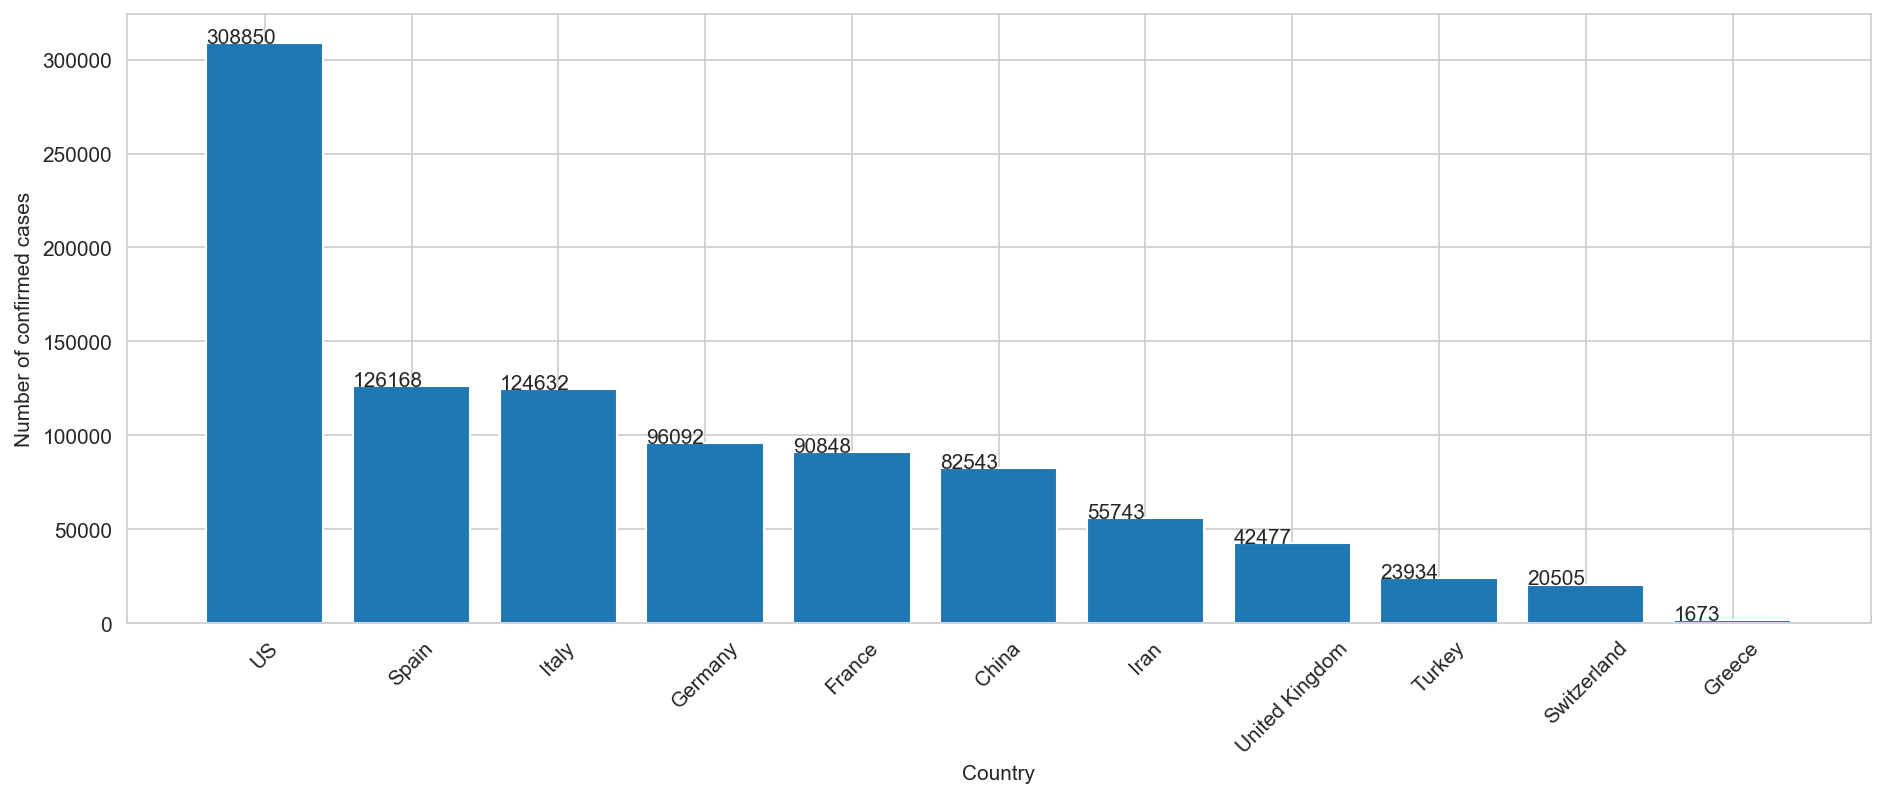

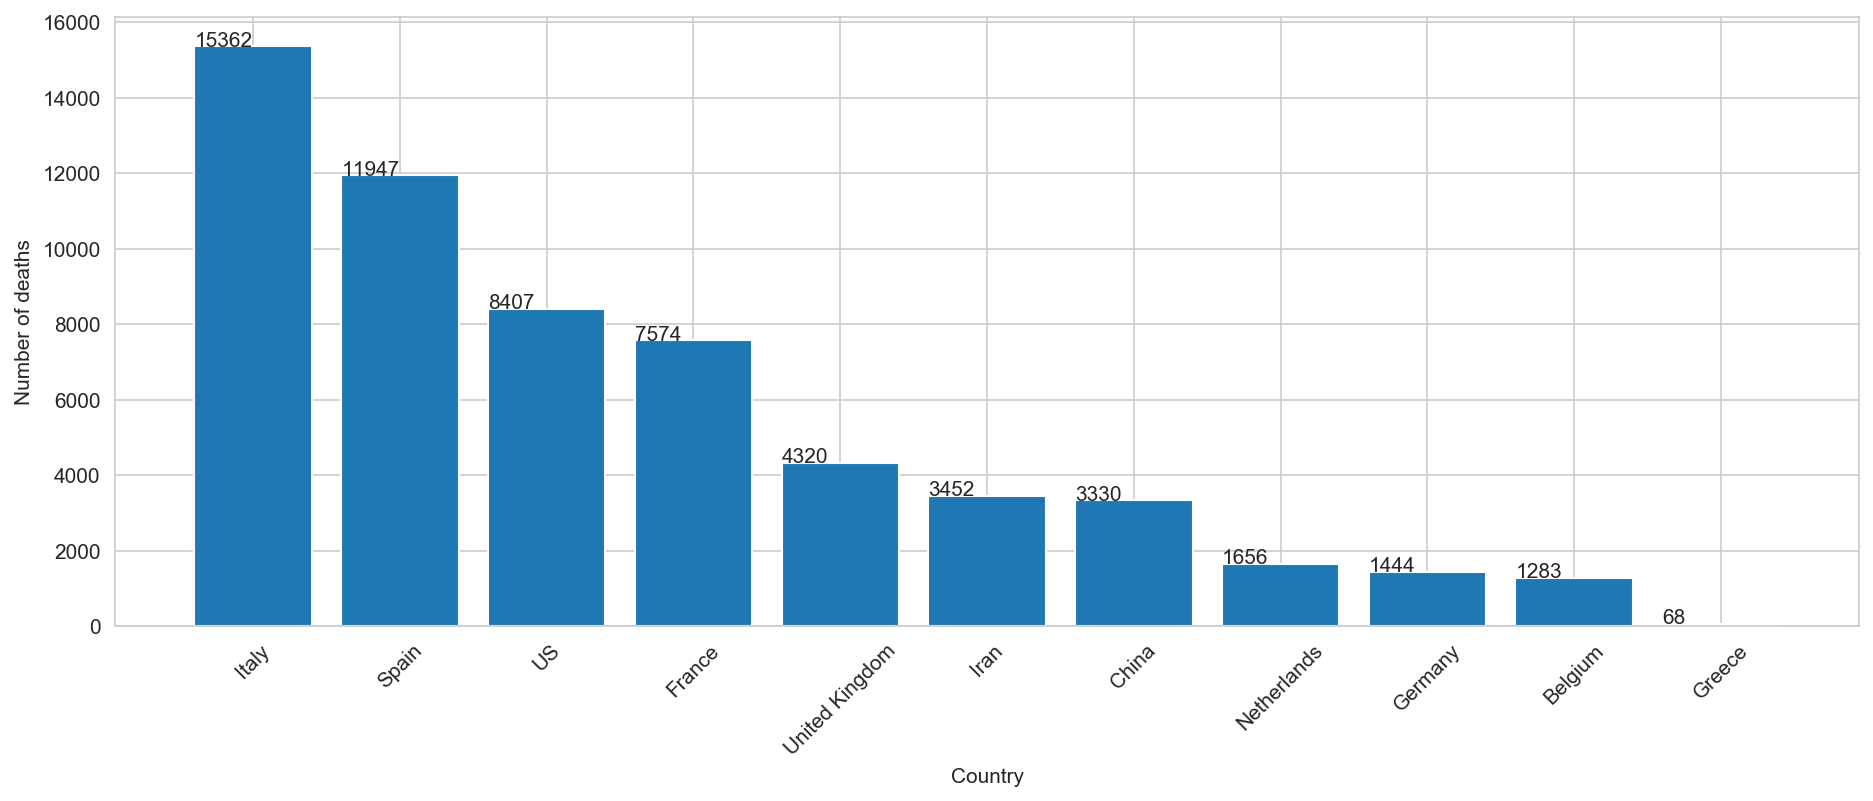

In [3]:
top_cases = covid19_module.top_countries(df_cases_raw)
top_deaths = covid19_module.top_countries(df_deaths_raw)
print("Latest update: ", df_cases_raw.columns[-1], "\n")
covid19_module.print_mortality_rates(df_cases, df_deaths, top_deaths)

covid19_module.plot_top_countries(df_cases, top_cases, "confirmed")
covid19_module.plot_top_countries(df_deaths, top_deaths, "deaths")

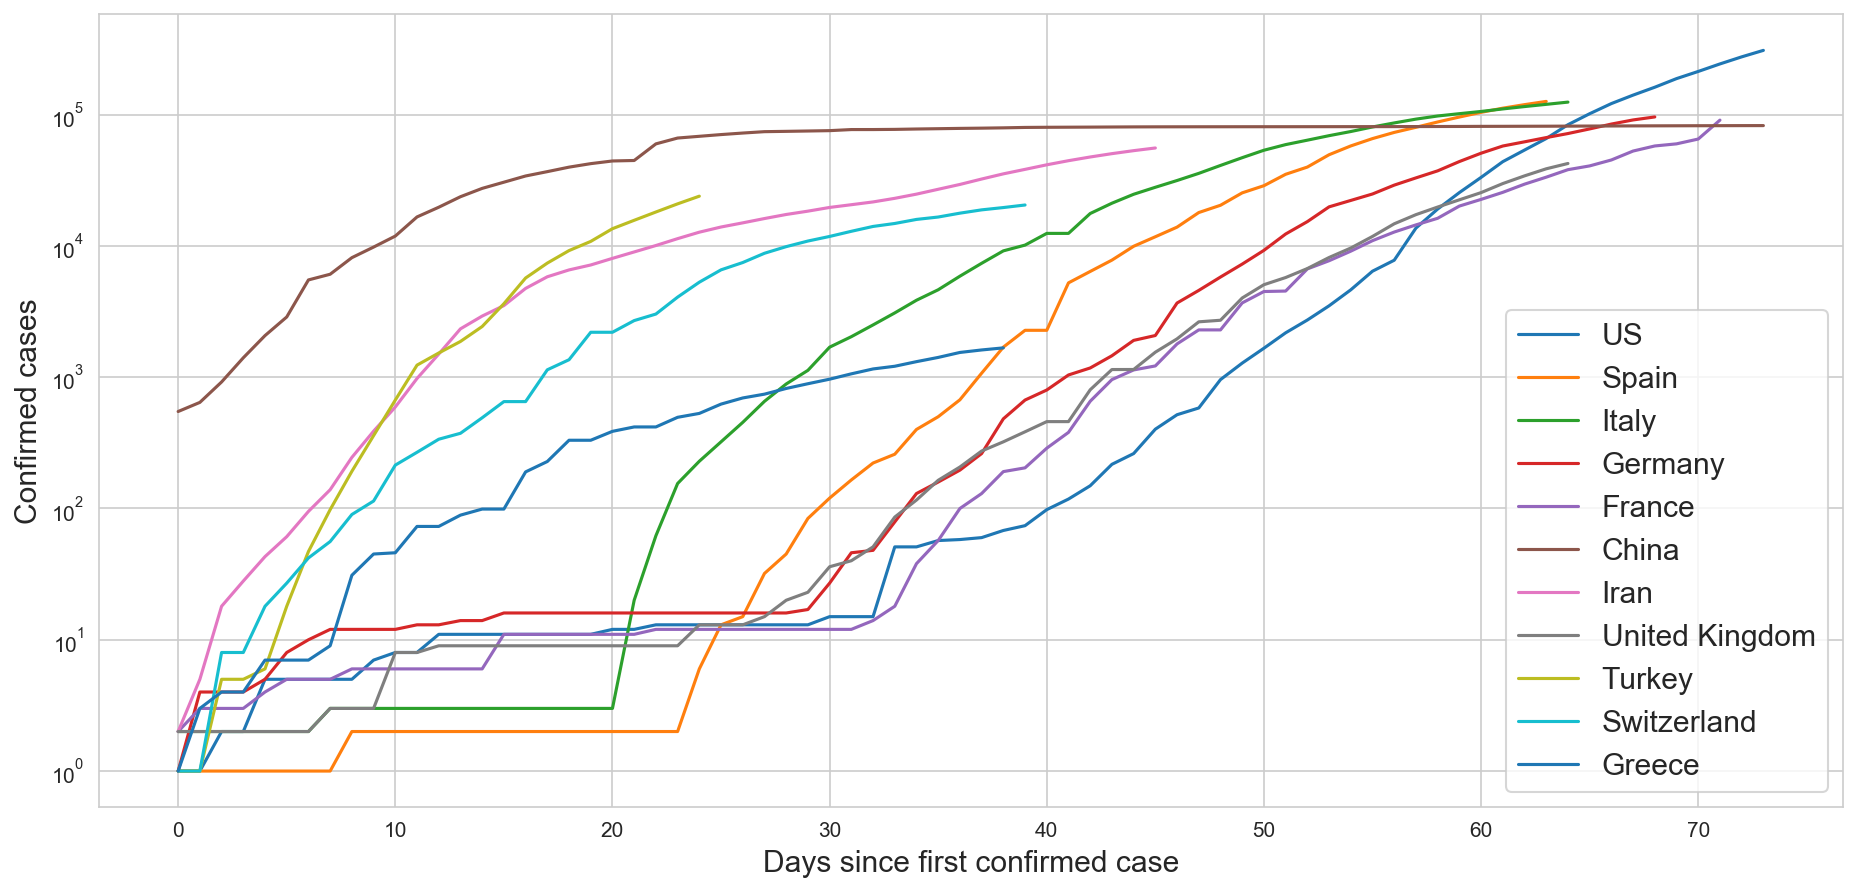

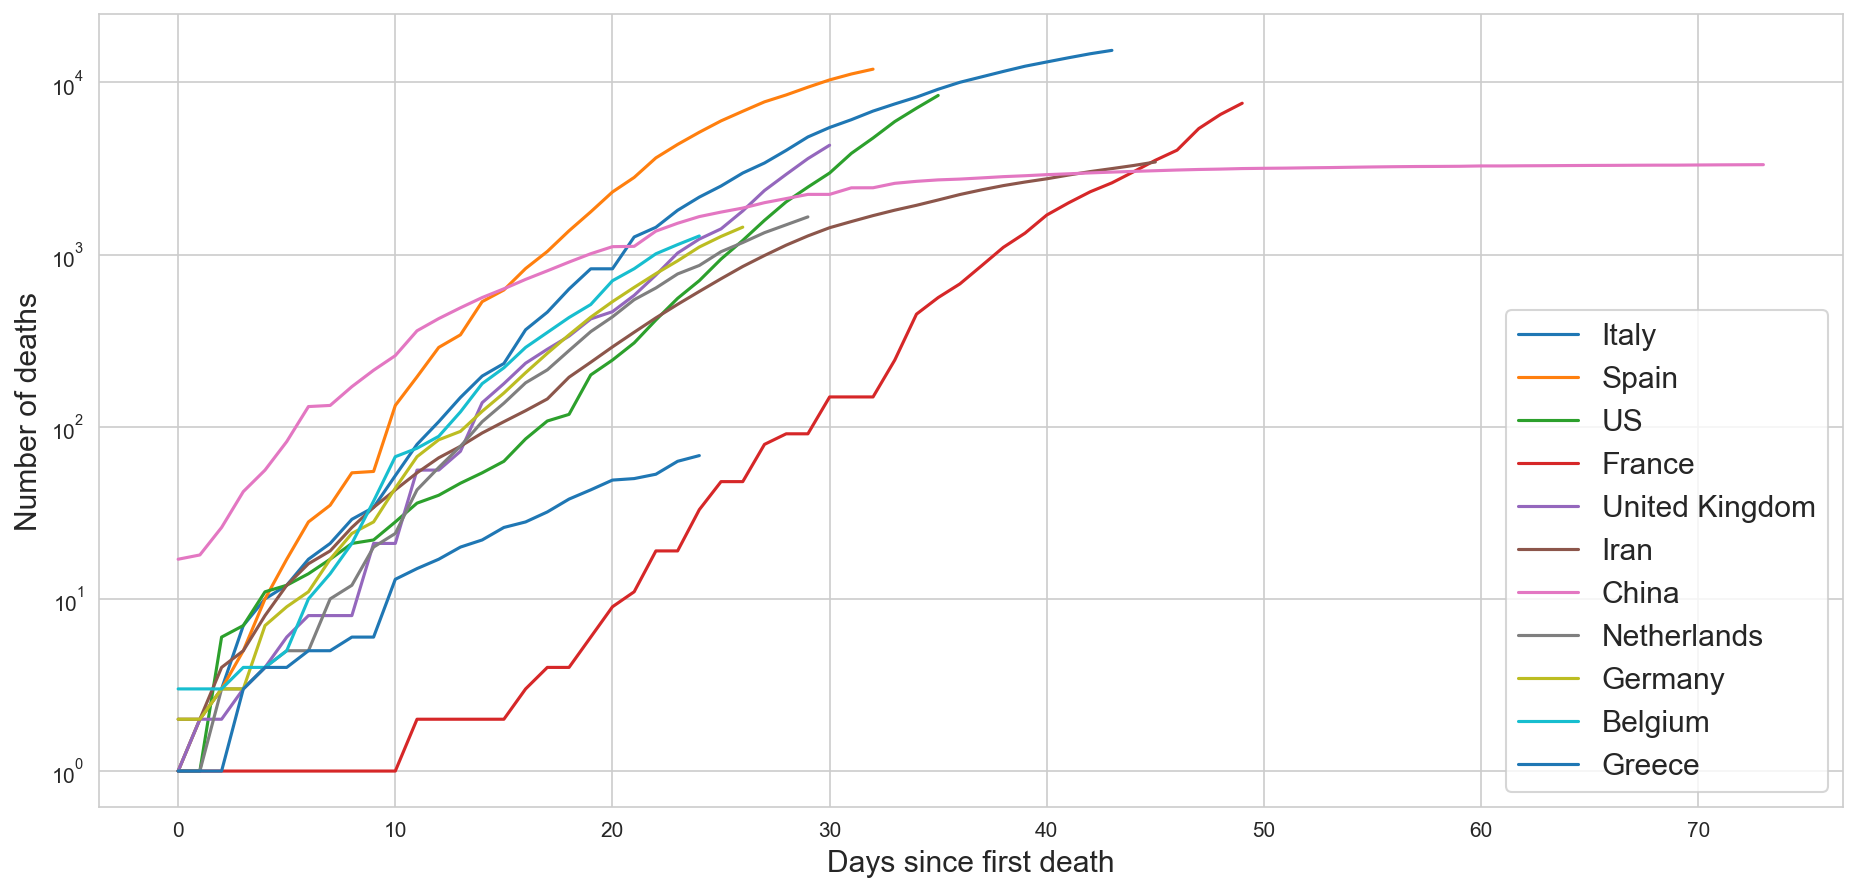

In [4]:
#%matplotlib notebook
covid19_module.plot_growth(df_cases, top_cases, "confirmed")
covid19_module.plot_growth(df_deaths, top_deaths, "deaths")


*** US ***

---Logistic fit---

R^2 =  0.999185116485189 

fit parametes: a= (4.79+/-0.14)e+05 b= 55901.6766+/-0.0012 c= 0.240+/-0.004 d= 25.2+/-0.6 e= (0.0+/-2.8)e+02

---Exponential fit---

R^2 =  0.9922944545235967 

fit parametes: a= 0.71+/-0.19 b= 0.181+/-0.004 c= (-1+/-6)e+02


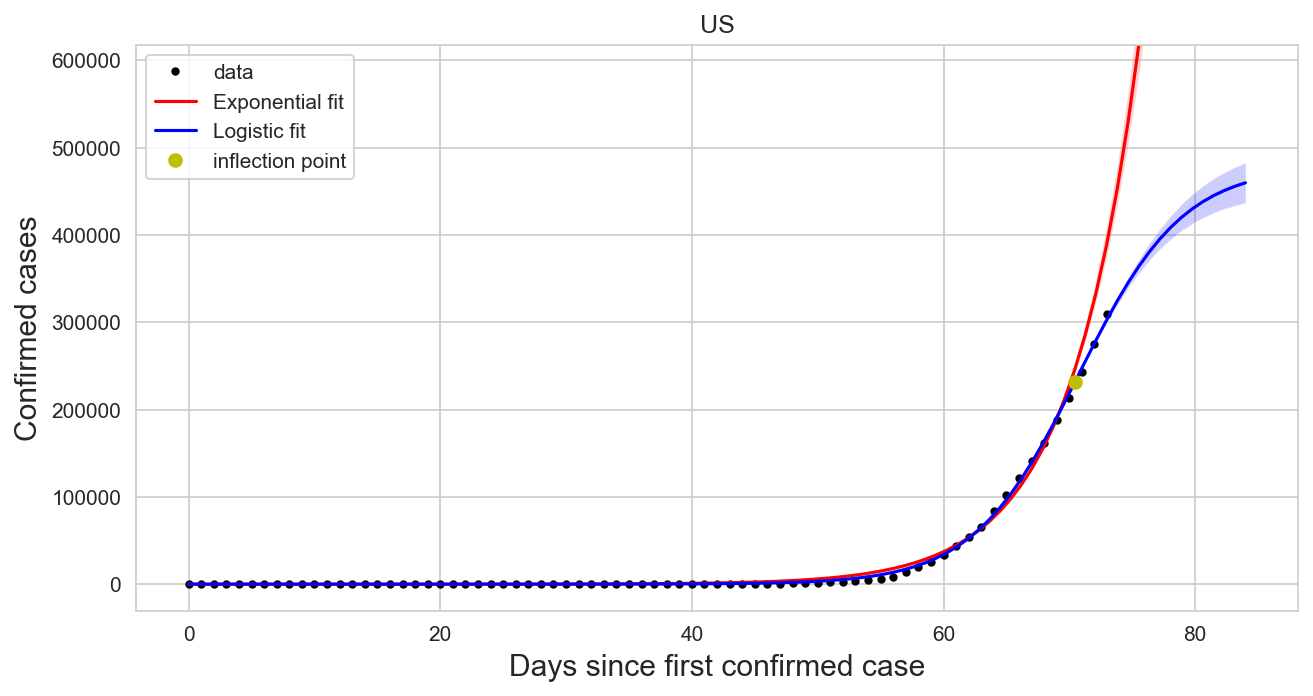


*** Spain ***

---Logistic fit---

R^2 =  0.9995870372138098 

fit parametes: a= (1.565+/-0.020)e+05 b= 56442.16322+/-0.00004 c= 0.2168+/-0.0029 d= 6.2+/-0.6 e= (0.0+/-1.2)e+02

---Exponential fit---

R^2 =  0.9955461602313324 

fit parametes: a= 6.4+/-1.1 b= 0.1678+/-0.0032 c= (-1.0+/-2.1)e+02


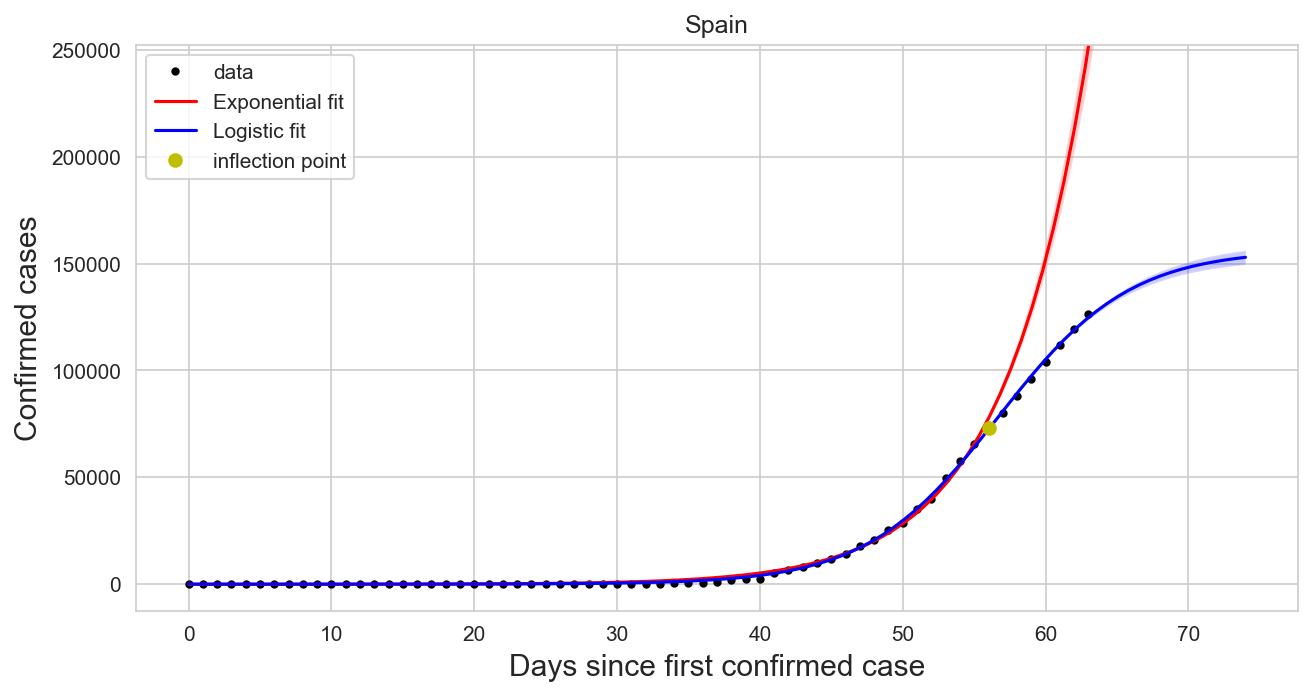


*** Italy ***

---Logistic fit---

R^2 =  0.999471653708118 

fit parametes: a= (1.386+/-0.014)e+05 b= 55231.46526+/-0.00005 c= 0.1769+/-0.0026 d= -8.8+/-0.8 e= (0.1+/-1.7)e+02

---Exponential fit---

R^2 =  0.9938434311780612 

fit parametes: a= 50+/-8 b= 0.1389+/-0.0034 c= (-1.0+/-2.7)e+02


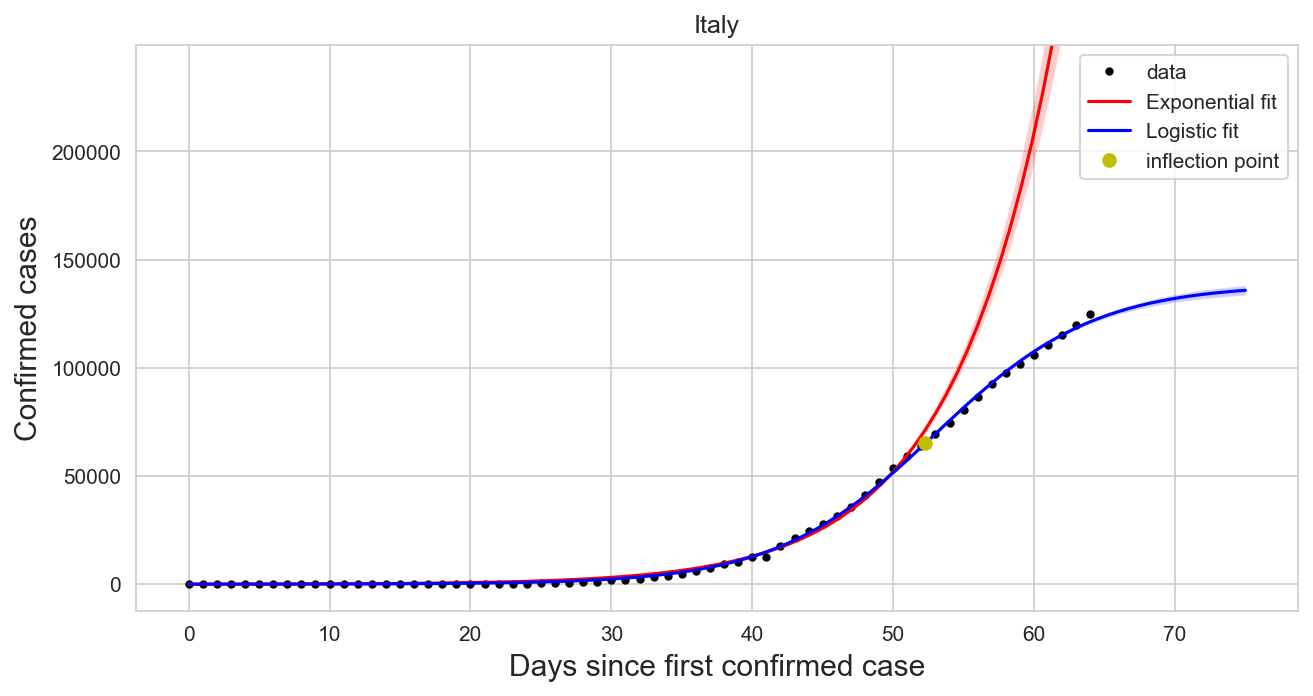


*** Germany ***

---Logistic fit---

R^2 =  0.999014153197804 

fit parametes: a= (1.207+/-0.024)e+05 b= 56977.01500+/-0.00004 c= 0.204+/-0.004 d= 8.2+/-0.9 e= (0.0+/-1.3)e+02

---Exponential fit---

R^2 =  0.993517966721715 

fit parametes: a= 3.6+/-0.8 b= 0.1592+/-0.0035 c= (-1.0+/-1.8)e+02


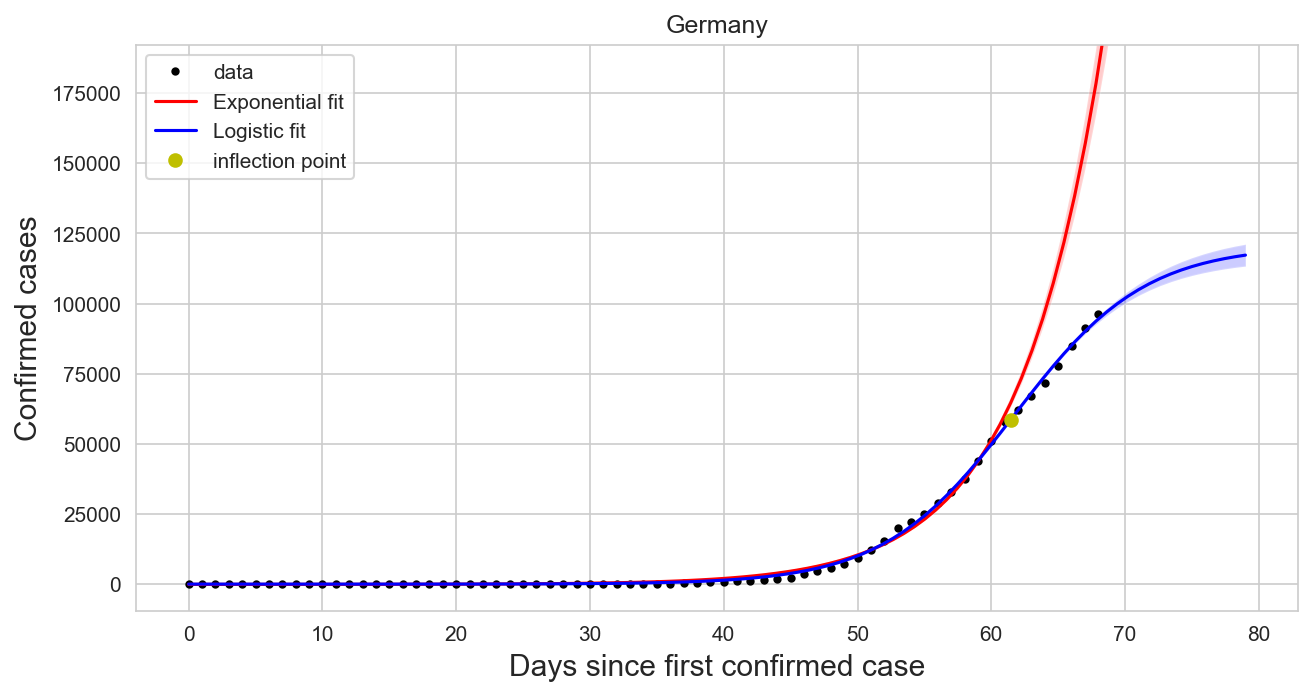


*** France ***

---Logistic fit---

R^2 =  0.9911921142625809 

fit parametes: a= (3.2+/-1.4)e+05 b= (0+/-4)e+09 c= 0.143+/-0.010 d= (0+/-4)e+05 e= (0.0+/-3.1)e+02

---Exponential fit---

R^2 =  0.9907024270027004 

fit parametes: a= 11.4+/-2.4 b= 0.1254+/-0.0031 c= (-1.0+/-2.9)e+02


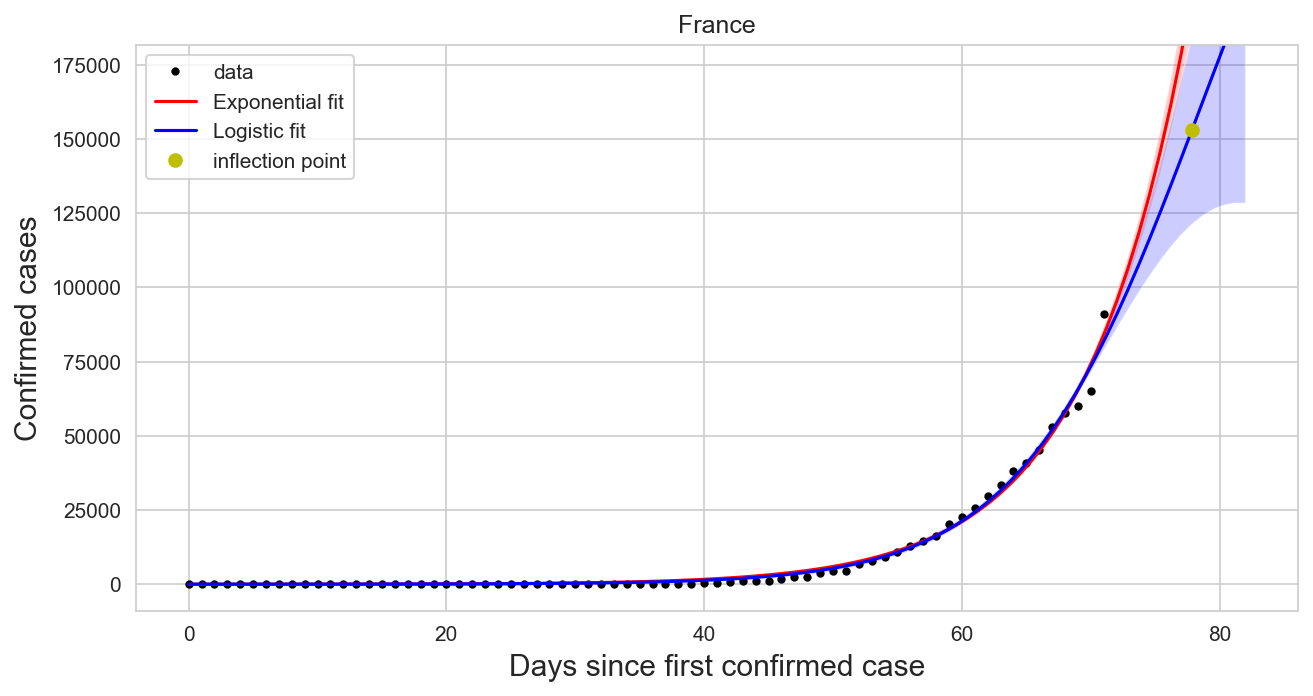


*** China ***

---Logistic fit---

R^2 =  0.9956873658085416 

fit parametes: a= (8.13+/-0.11)e+04 b= (0.0+/-1.3)e+10 c= 0.220+/-0.009 d= (-0.0+/-1.7)e+06 e= (0.0+/-1.0)e+03

---Exponential fit---

R^2 =  0.9404488567115904 

fit parametes: a= (1.0+/-0.6)e+03 b= 0.22+/-0.04 c= (1.0+/-2.0)e+03


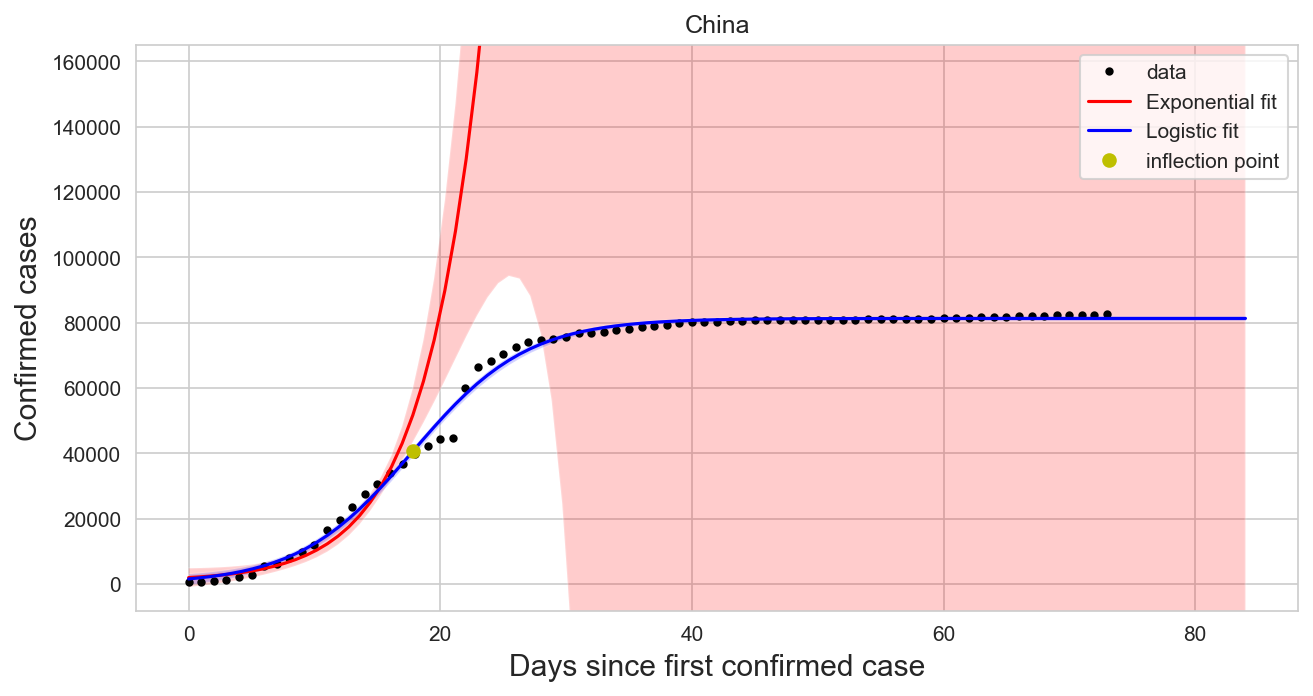


*** Iran ***

---Logistic fit---

R^2 =  0.994017344733488 

fit parametes: a= (1.10+/-0.21)e+05 b= 43698.9154+/-0.0015 c= 0.107+/-0.010 d= -55+/-7 e= (0+/-7)e+02

---Exponential fit---

R^2 =  0.9802525820795991 

fit parametes: a= (1.00+/-0.23)e+03 b= 0.092+/-0.005 c= (8+/-8)e+02


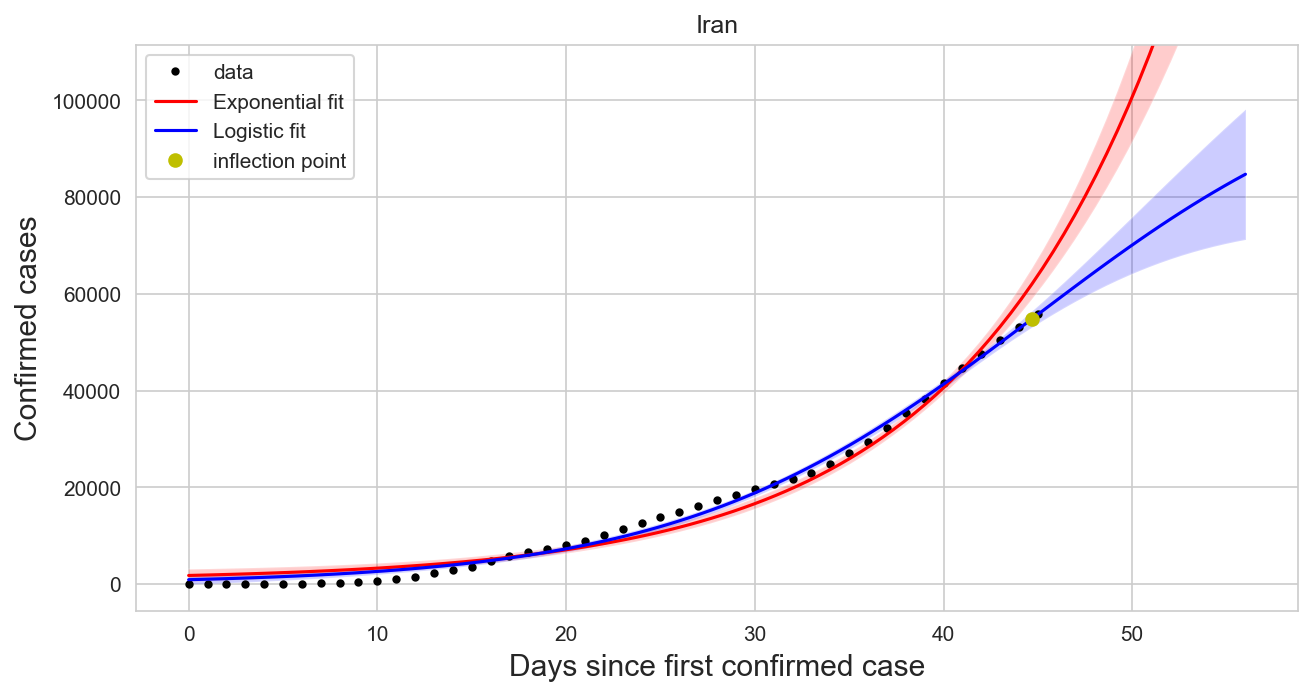


*** United Kingdom ***

---Logistic fit---

R^2 =  0.9995671008768395 

fit parametes: a= (8.22+/-0.28)e+04 b= 54507.26320+/-0.00007 c= 0.2056+/-0.0031 d= 10.6+/-0.5 e= 0+/-35

---Exponential fit---

R^2 =  0.9966970383899998 

fit parametes: a= 2.33+/-0.34 b= 0.1549+/-0.0024 c= (-1.0+/-0.8)e+02


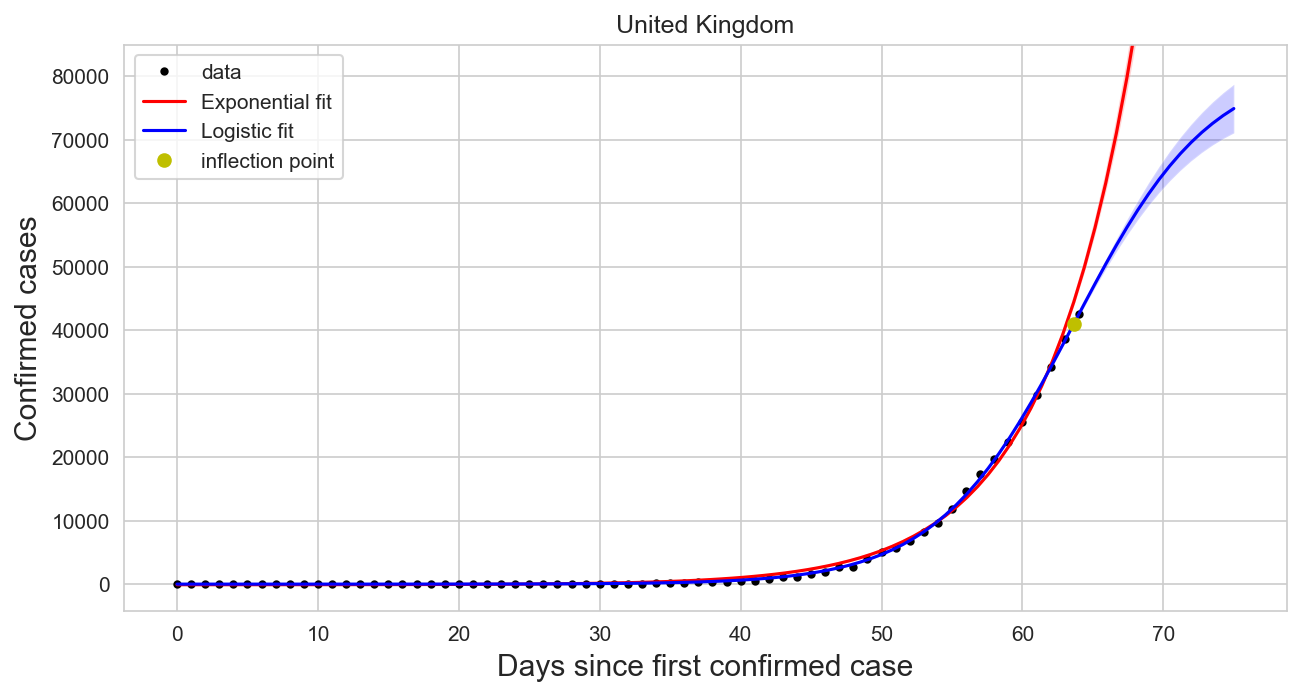


*** Turkey ***

---Logistic fit---

R^2 =  0.9982284619761992 

fit parametes: a= (3.25+/-0.19)e+04 b= 52714.66044+/-0.00011 c= 0.325+/-0.017 d= -12.4+/-1.4 e= (0.0+/-1.3)e+02

---Exponential fit---

R^2 =  0.989779029914441 

fit parametes: a= 87+/-25 b= 0.255+/-0.015 c= (-1.0+/-1.8)e+02


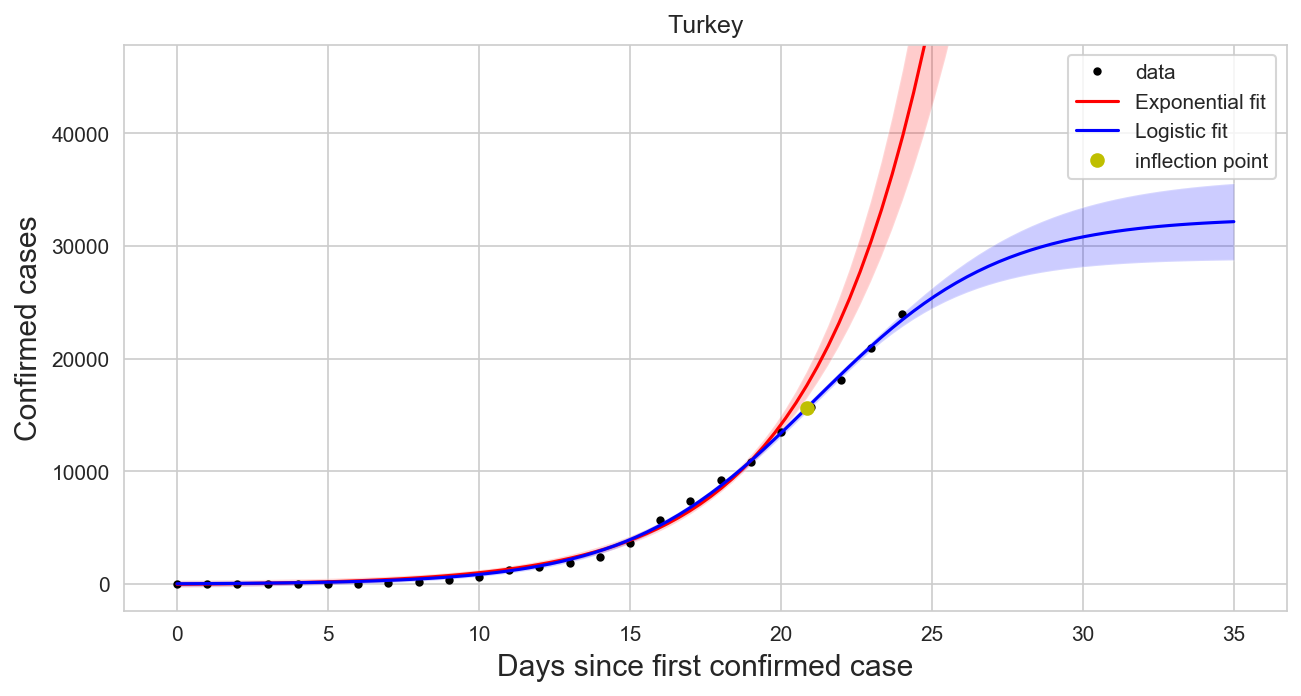


*** Switzerland ***

---Logistic fit---

R^2 =  0.9980795533019508 

fit parametes: a= (2.21+/-0.05)e+04 b= 53487.23707+/-0.00014 c= 0.224+/-0.008 d= -19.4+/-1.6 e= (0.0+/-1.0)e+02

---Exponential fit---

R^2 =  0.990190933472128 

fit parametes: a= 76+/-17 b= 0.174+/-0.008 c= (-1.0+/-1.2)e+02


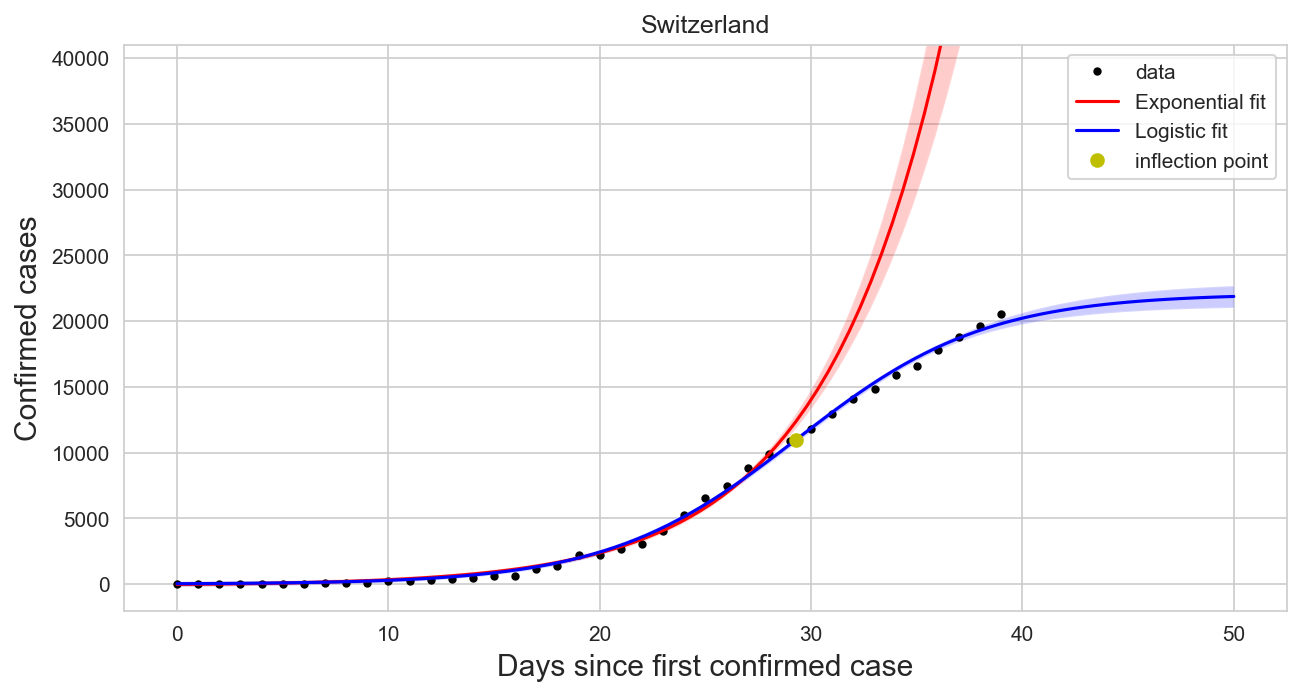


*** Greece ***

---Logistic fit---

R^2 =  0.9962272818804516 

fit parametes: a= (2.33+/-0.17)e+03 b= 45208.3083+/-0.0006 c= 0.151+/-0.010 d= -39+/-4 e= 0+/-16

---Exponential fit---

R^2 =  0.9906542611260196 

fit parametes: a= 71+/-12 b= 0.091+/-0.005 c= -100+/-23


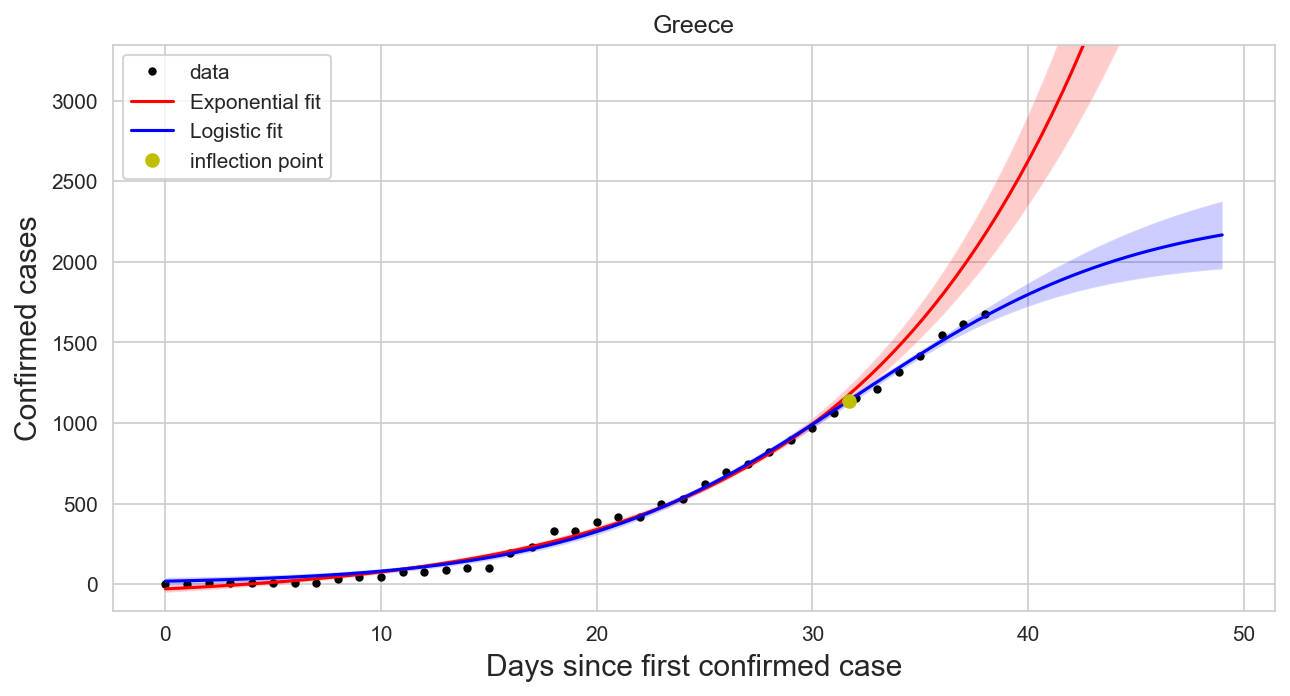

In [5]:
top_countries = top_cases.tolist()
top_countries.append("Greece")
for country in top_countries:
    try:
        print("\n***", country, "***")
        log_popt, log_pcov, inflection_p = covid19_module.fit_logistic(country, df_cases)
        fit_end = inflection_p[1]
        if fit_end > df_cases[country].dropna().shape[0]:
            fit_end = df_cases[country].dropna().shape[0]
        exp_popt, exp_pcov, R2 = covid19_module.fit_exponential(country, df_cases, [0,fit_end])
        covid19_module.plot_fits(country, df_cases, exp_popt, exp_pcov, log_popt, log_pcov, inflection_p[0], "confirmed")
    except:
        pass


*** Italy ***

---Logistic fit---

R^2 =  0.9993197119567514 

fit parametes: a= (1.87+/-0.04)e+04 b= 48992.16293+/-0.00012 c= 0.185+/-0.004 d= -23.3+/-1.1 e= (0+/-4)e+01

---Exponential fit---

R^2 =  0.9912205718656002 

fit parametes: a= 78+/-15 b= 0.139+/-0.006 c= (-1.0+/-0.8)e+02


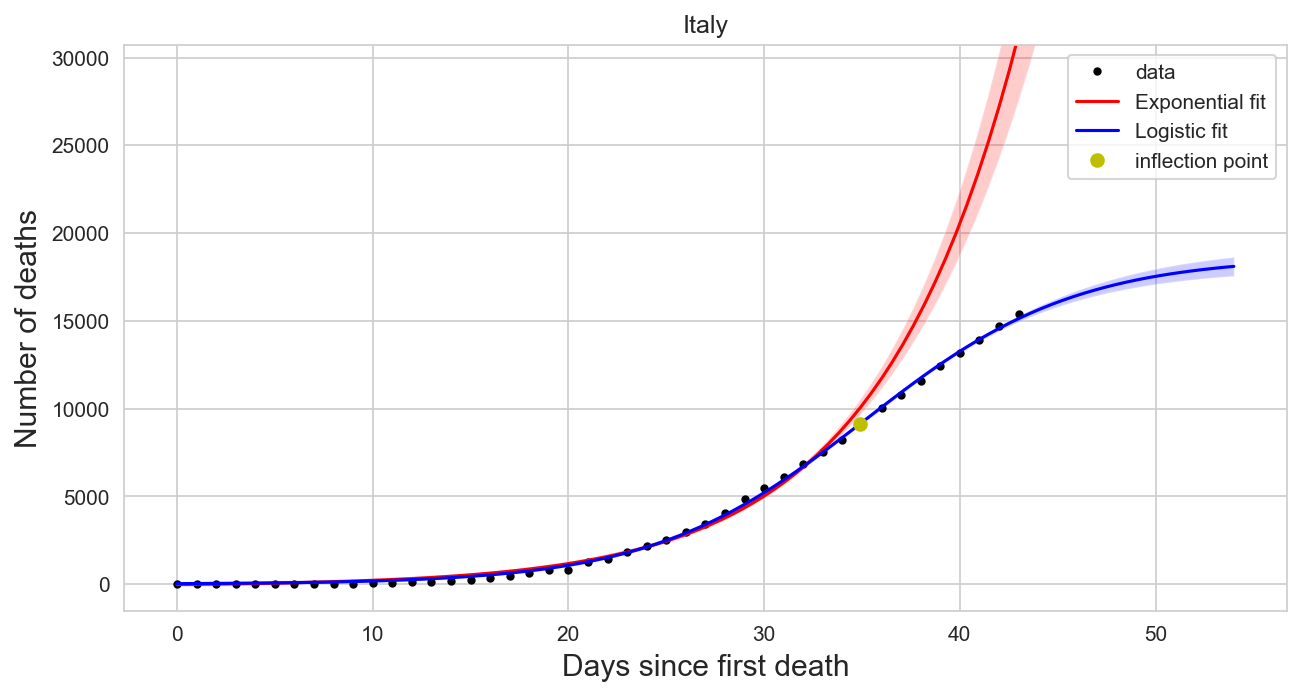


*** Spain ***

---Logistic fit---

R^2 =  0.9993724098635699 

fit parametes: a= (1.465+/-0.035)e+04 b= (0.0+/-2.8)e+10 c= 0.258+/-0.007 d= (-0.0+/-2.1)e+06 e= 0+/-33

---Exponential fit---

R^2 =  0.9935784986074635 

fit parametes: a= 52+/-10 b= 0.191+/-0.008 c= (-1.0+/-0.6)e+02


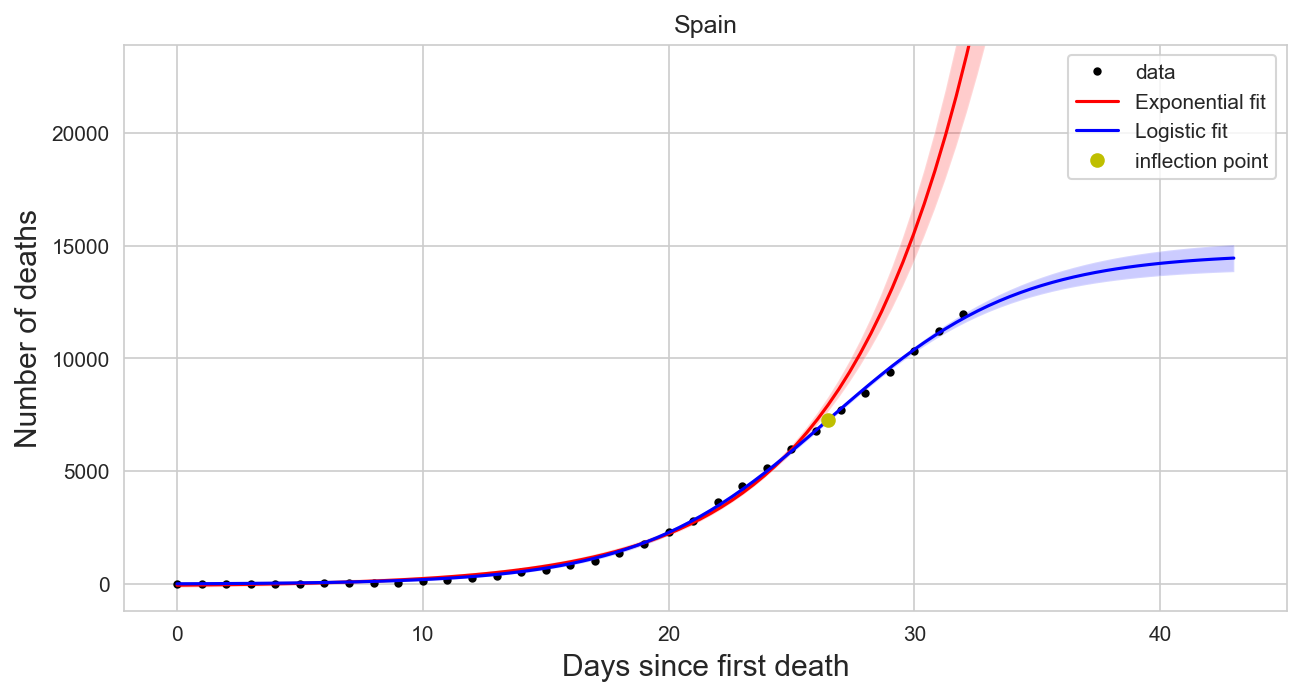


*** US ***

---Logistic fit---

R^2 =  0.9997876633422015 

fit parametes: a= (2.31+/-0.14)e+04 b= (0+/-4)e+09 c= 0.262+/-0.004 d= (-0.0+/-2.9)e+05 e= 1+/-8

---Exponential fit---

R^2 =  0.9983112979987383 

fit parametes: a= 6.1+/-0.7 b= 0.2074+/-0.0032 c= -60+/-22


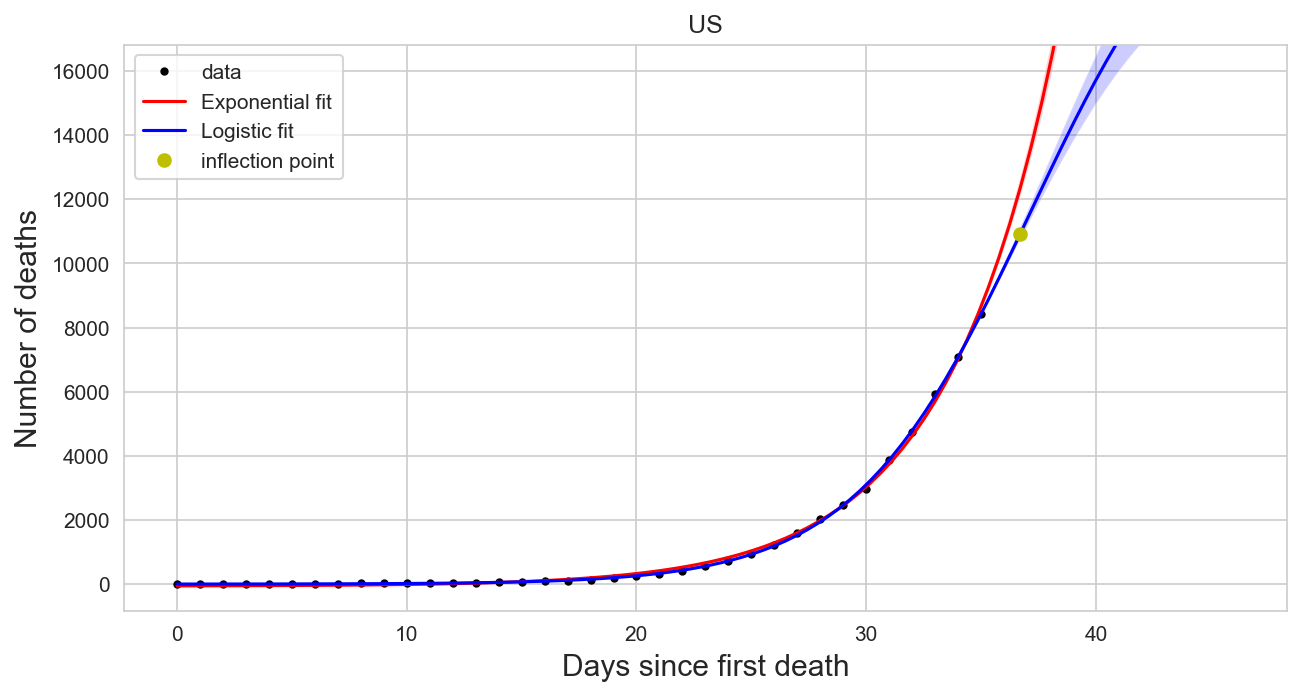


*** France ***

---Logistic fit---

R^2 =  0.9967774209383895 

fit parametes: a= (2+/-4)e+05 b= 55528.0+/-0.7 c= 0.186+/-0.010 d= 7+/-11 e= 0+/-22

---Exponential fit---

R^2 =  0.9969626159869808 

fit parametes: a= 1.18+/-0.17 b= 0.1791+/-0.0030 c= -33+/-19


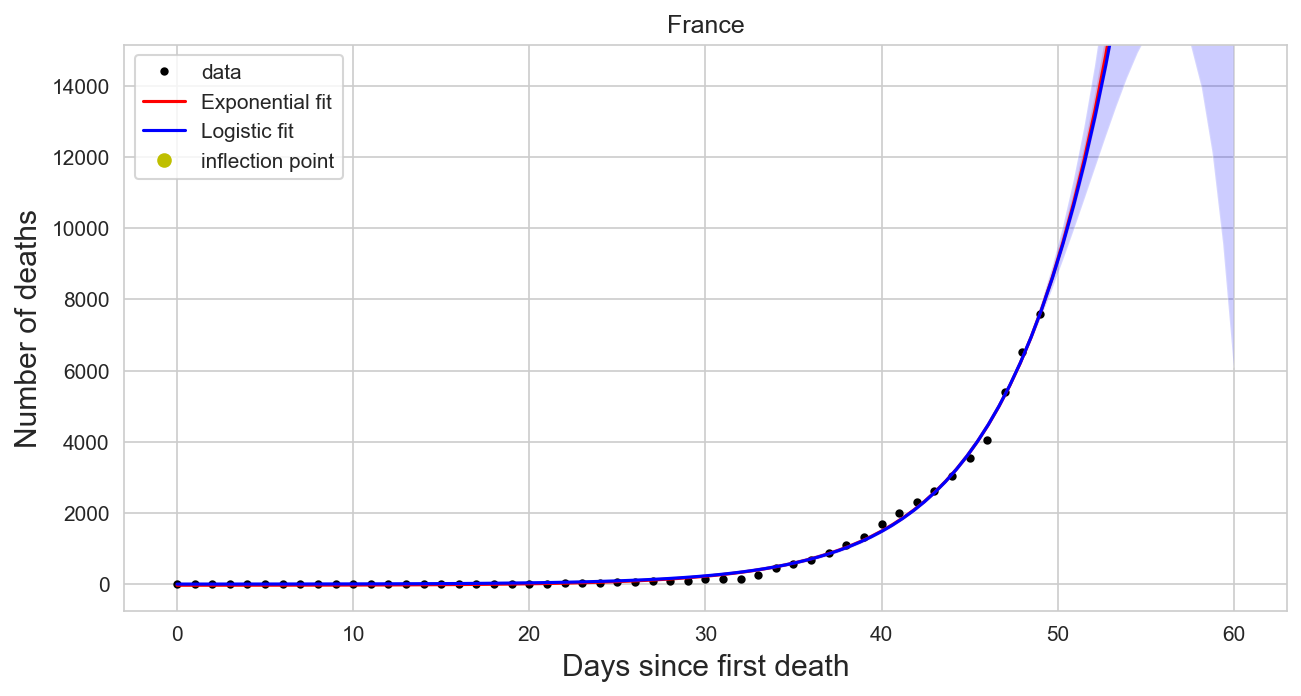


*** United Kingdom ***

---Logistic fit---

R^2 =  0.9990430770862732 

fit parametes: a= (3.3+/-1.6)e+04 b= 53810.266+/-0.005 c= 0.232+/-0.010 d= -8.9+/-1.0 e= 0+/-12

---Exponential fit---

R^2 =  0.9989573241356902 

fit parametes: a= 7.3+/-0.6 b= 0.2133+/-0.0029 c= -19+/-11


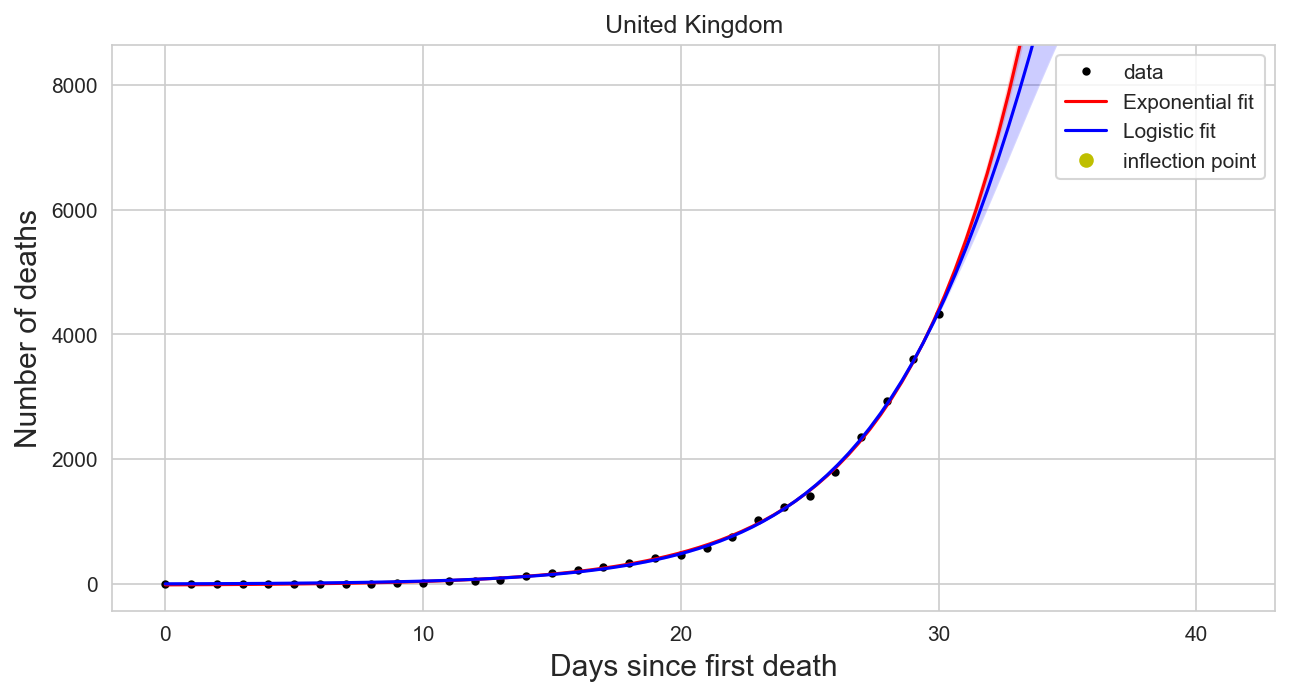


*** Iran ***

---Logistic fit---

R^2 =  0.99803859718532 

fit parametes: a= (3.79+/-0.09)e+03 b= 47059.77357+/-0.00026 c= 0.170+/-0.006 d= -29.8+/-2.0 e= 0+/-17

---Exponential fit---

R^2 =  0.990662067781547 

fit parametes: a= 41+/-7 b= 0.118+/-0.005 c= -90+/-24


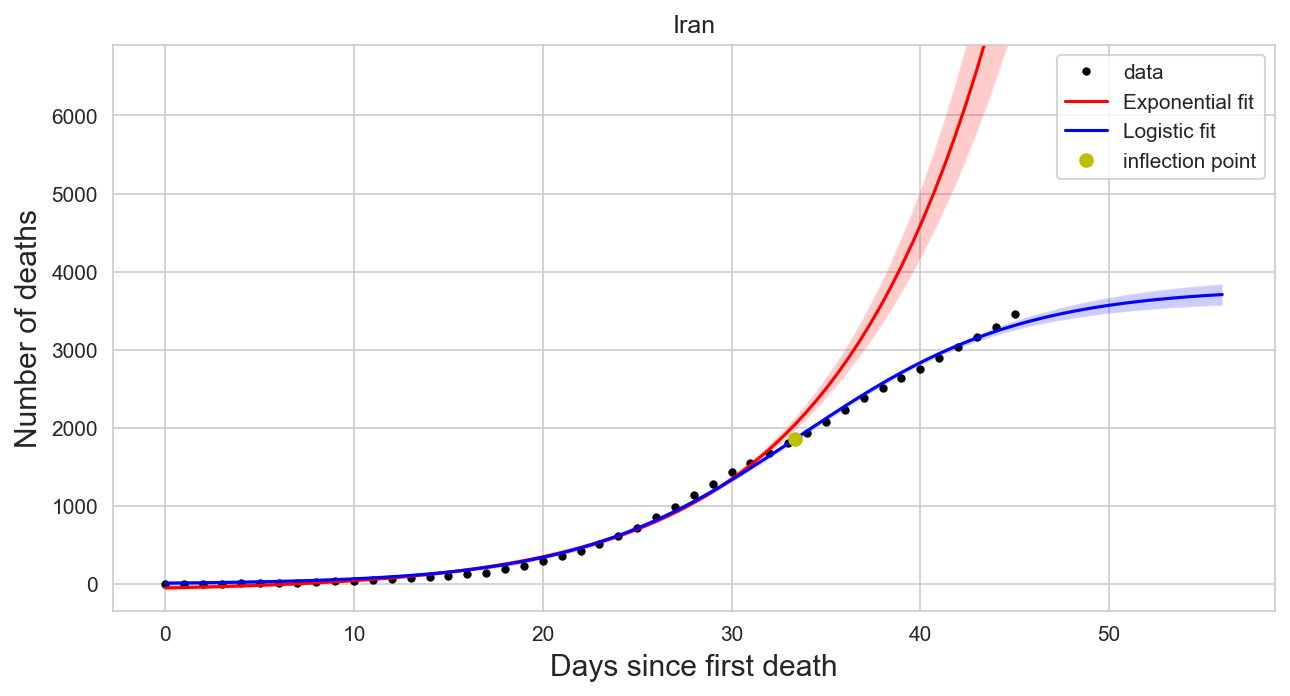


*** China ***

---Logistic fit---

R^2 =  0.9983489952397432 

fit parametes: a= 3262+/-30 b= (0+/-9)e+09 c= 0.153+/-0.004 d= (-0.0+/-2.2)e+06 e= 0+/-25

---Exponential fit---

R^2 =  0.9901697819742595 

fit parametes: a= 132+/-27 b= 0.110+/-0.008 c= (-1.0+/-0.5)e+02


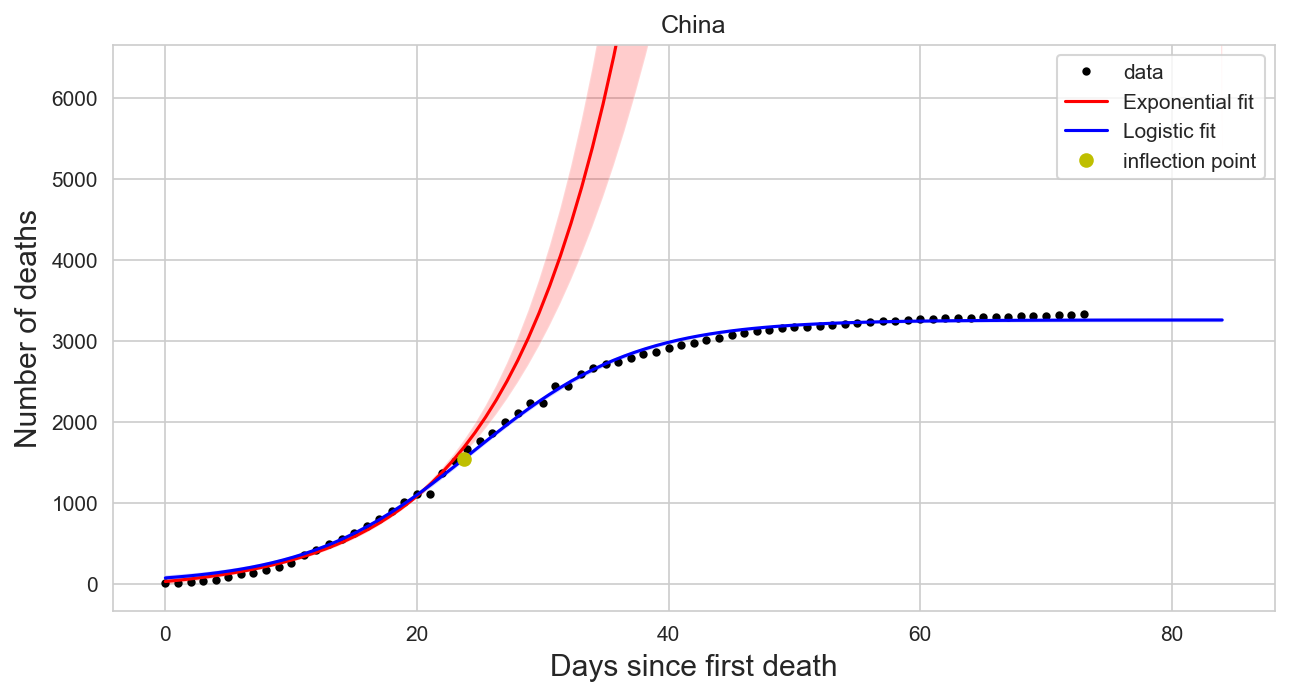


*** Netherlands ***

---Logistic fit---

R^2 =  0.9994610535555146 

fit parametes: a= (2.47+/-0.09)e+03 b= (0.0+/-2.2)e+10 c= 0.249+/-0.007 d= (-0.0+/-1.7)e+06 e= 0+/-5

---Exponential fit---

R^2 =  0.9955941139832917 

fit parametes: a= 16.8+/-2.4 b= 0.166+/-0.006 c= -43+/-10


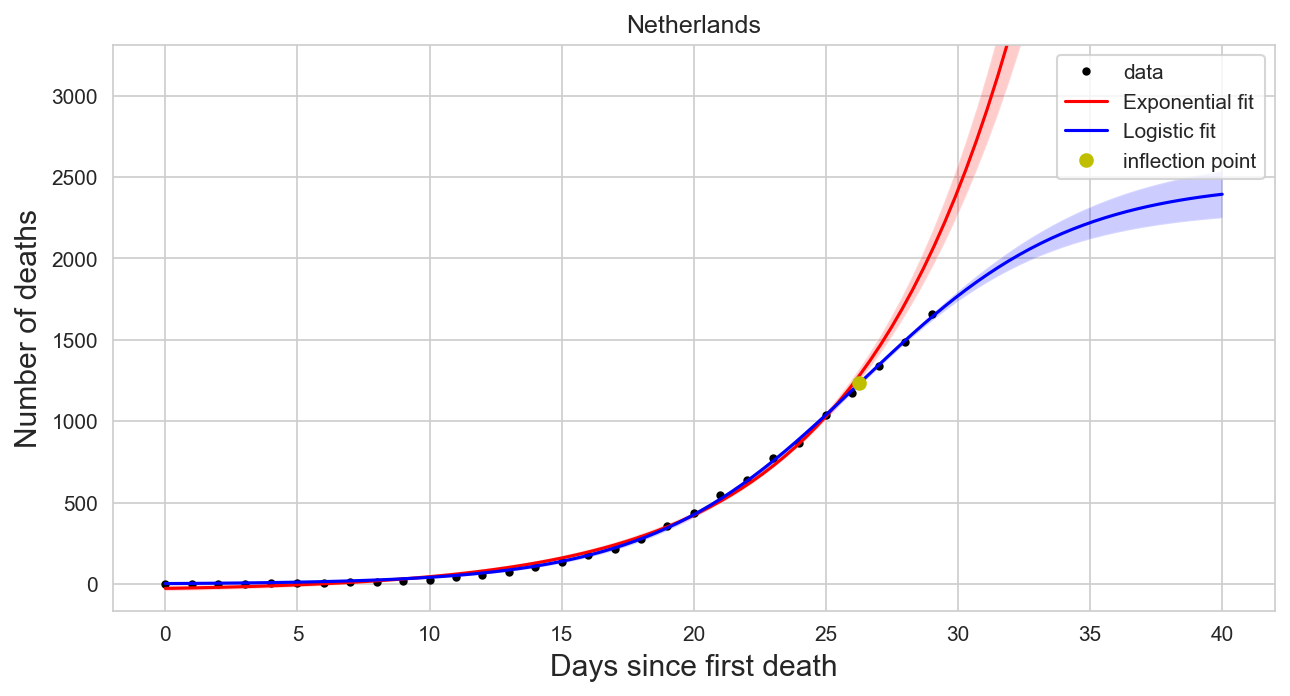


*** Germany ***

---Logistic fit---

R^2 =  0.999810050992161 

fit parametes: a= (2.62+/-0.09)e+03 b= (0.0+/-1.7)e+10 c= 0.265+/-0.005 d= (-0.0+/-1.3)e+06 e= 0.0+/-2.5

---Exponential fit---

R^2 =  0.9974718719737448 

fit parametes: a= 14.3+/-1.6 b= 0.182+/-0.005 c= -33+/-8


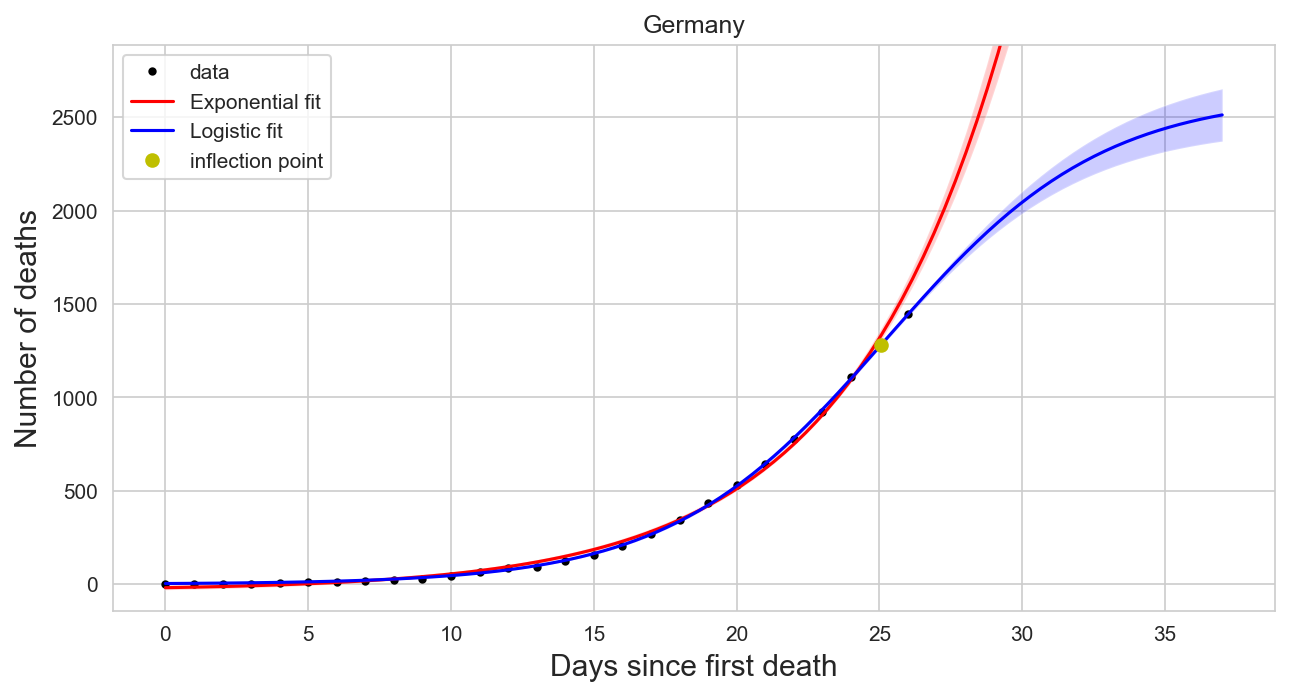


*** Belgium ***

---Logistic fit---

R^2 =  0.9987628339288033 

fit parametes: a= (2.15+/-0.16)e+03 b= (0.0+/-2.8)e+10 c= 0.293+/-0.015 d= (-0.0+/-1.9)e+06 e= 0+/-6

---Exponential fit---

R^2 =  0.9979038645339324 

fit parametes: a= 10.3+/-1.2 b= 0.210+/-0.005 c= -22+/-6


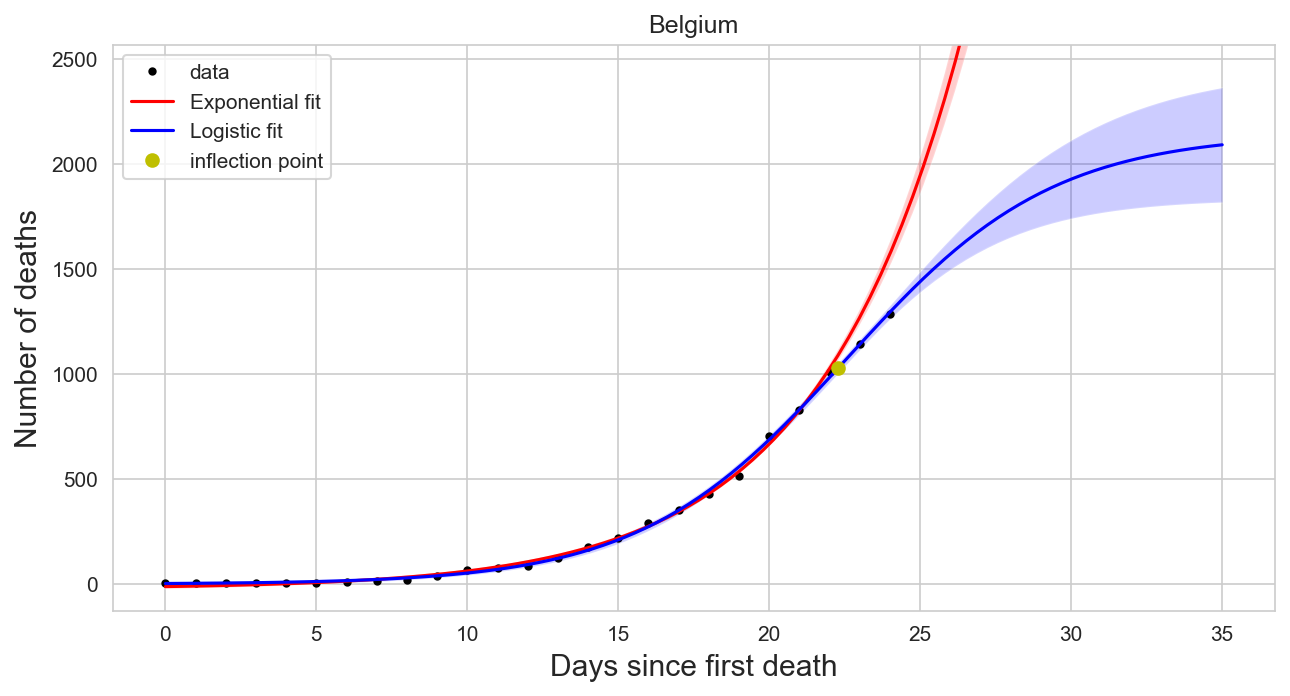


*** Greece ***

---Logistic fit---

R^2 =  0.9940077040325457 

fit parametes: a= 99+/-15 b= (0+/-8)e+10 c= 0.198+/-0.025 d= (-0+/-8)e+06 e= 0.0+/-1.4

---Exponential fit---

R^2 =  0.9926048025966543 

fit parametes: a= 5.1+/-1.0 b= 0.118+/-0.009 c= -5.1+/-1.5


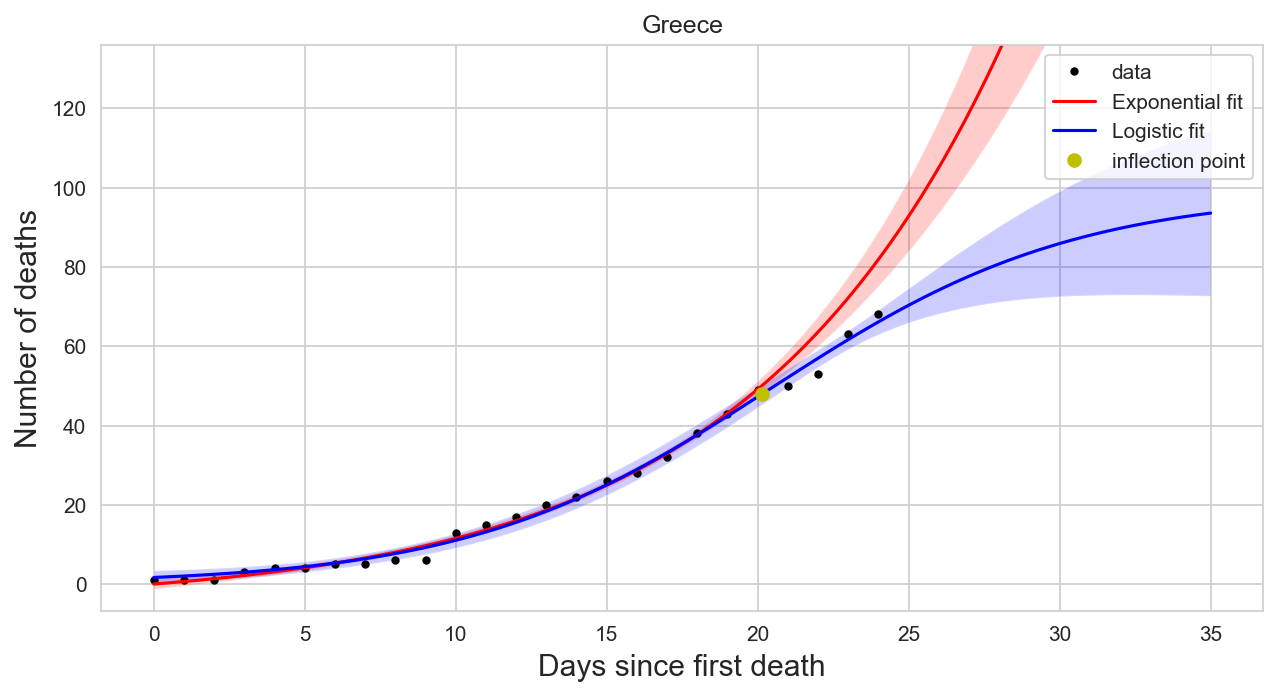

In [6]:
top_countries = top_deaths.tolist()
top_countries.append("Greece")
for country in top_countries:
    try:
        print("\n***", country, "***")
        log_popt, log_pcov, inflection_p = covid19_module.fit_logistic(country, df_deaths)
        fit_end = inflection_p[1]
        if fit_end > df_deaths[country].dropna().shape[0]:
            fit_end = df_deaths[country].dropna().shape[0]
        exp_popt, exp_pcov, R2 = covid19_module.fit_exponential(country, df_deaths, [0,fit_end])
        covid19_module.plot_fits(country, df_deaths, exp_popt, exp_pcov, log_popt, log_pcov, inflection_p[0], "deaths")
    except:
        pass